## Notebook for numerical resolution analysis and plots of injected waveforms

In [3]:
# imports
from matplotlib import rc
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import json
from Generate_dCS_Strain import *
from scipy.signal import argrelextrema
rc('text', usetex=True)
from scipy.optimize import fmin
import seaborn as sns

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [4]:
def CutTimes(time, data, TLow, TUp): 
    """ Cut time and data to be between 
        TLow and TUp  """
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

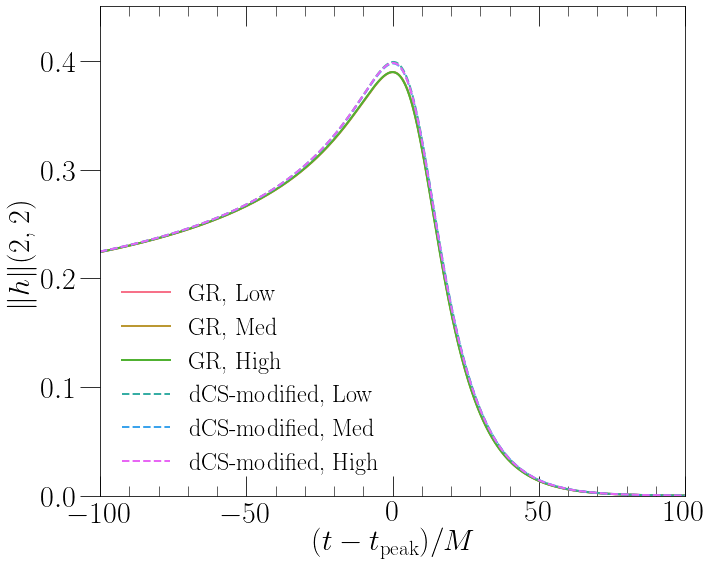

In [7]:
# Plot the SXS format strains from the simulations
def PlotSXSStrainResolutions():
    
    f, ax = plt.subplots(1, figsize=(10,8))
    mode = (2,2)
    order = 2
    
    cs = sns.color_palette('husl', n_colors=6)
    
    i = 0
    for ell, label, ls in zip([0, 0.226], ['GR', 'dCS-modified'], ['-', '--']):
        
        for lev, res in zip([0, 1, 2], ['Low', 'Med', 'High']):

            p = "Waveforms/"
            ## Grab delta psi4 and compute delta h
            time, strain = ReadExtrapolatedMode(p, "BackgroundStrain", mode, lev, order)
        
            peak_time = GetPeakTimeMode(time, np.abs(strain))
            time = time - peak_time
        
            delta_time, delta_strain = ReadExtrapolatedMode(p, "DeltaStrain", mode, lev, order)
            delta_time = delta_time - peak_time

            combined = strain + ell**4 * delta_strain
            ax.plot(time, np.abs(combined), label=label+', ' + res, lw = 2.0, ls=ls, color=cs[i])
            i = i + 1


    legend = ax.legend(fontsize=24, loc='best', frameon=False, ncol=1)
    ax.set_ylabel(r'$\|h\|$' + str(mode), fontsize=30)
    ax.set_xlim(-100, 100)
    ax.set_ylim(0.0, 0.45)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig('SXSResolutions.pdf')
    plt.show()     

PlotSXSStrainResolutions()

## Plot SXS waveforms 

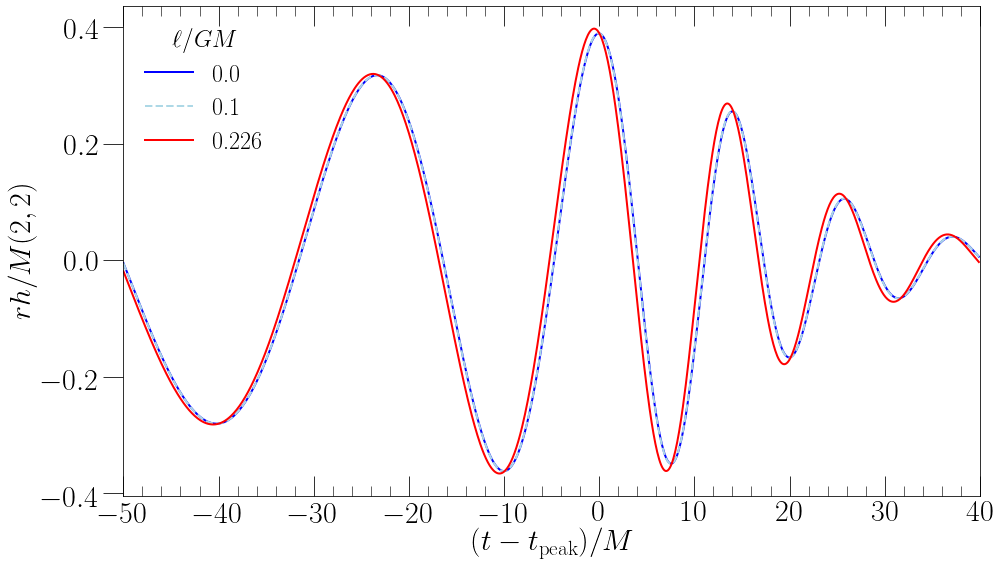

In [9]:
# Plot the strains with resolution

def PlotStrainElls():
    
    f, ax = plt.subplots(1, figsize=(14,8))
    mode = (2,2)
    order = 2
    start = -50
    stop = 40
    p = "Waveforms"
    
    ells = [0.0, 0.1, 0.226]
    colors = ['blue', 'lightblue', 'red']
    lss = ['-','--','-']
    for ell, c, ls in zip(ells, colors, lss):
        time, strain = ReadExtrapolatedMode(p, "dCSModified", mode, 2, order, ell=ell)
        time = SubtractPeakTimeMode(time, strain)
        time, strain = CutTimes(time, strain, start, stop)
        ax.plot(time, np.real(strain), label=ell, lw=2.0, color=c, ls=ls)

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1, title='$\ell/GM$')
    plt.setp(legend.get_title(),fontsize=24)
    ax.set_ylabel('$rh/M (2,2)$', fontsize=30)

    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    ax.set_xlim(start, stop)
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig('SXS_format.pdf')
    plt.show()     

PlotStrainElls()

# Plot SXS waveforms with resolution for various modes

(2, 2)


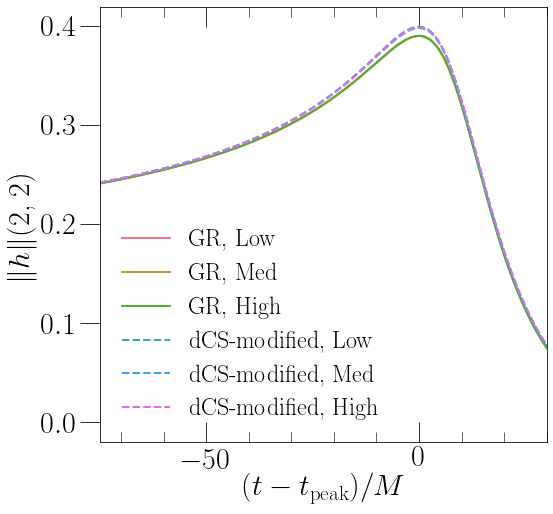

(4, 4)


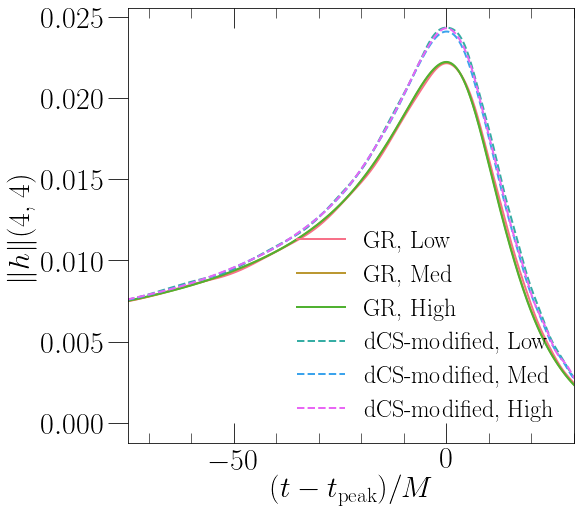

(3, 3)


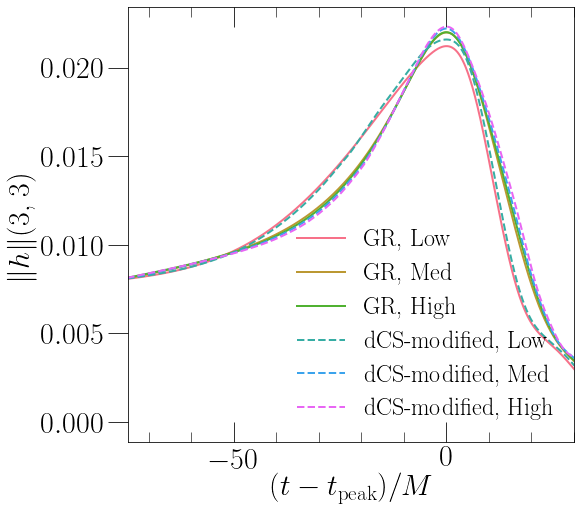

(3, 2)


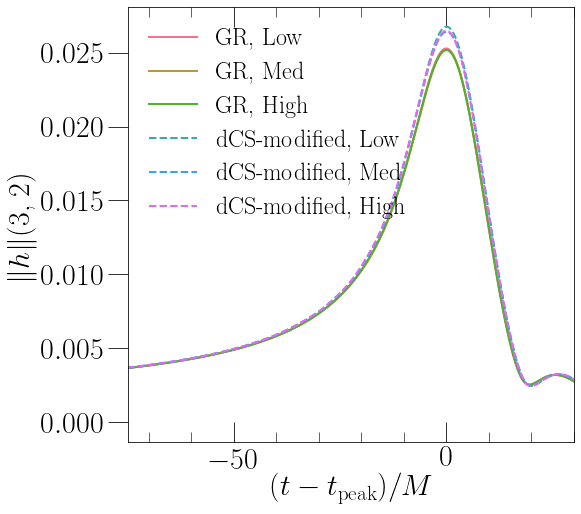

(2, 1)


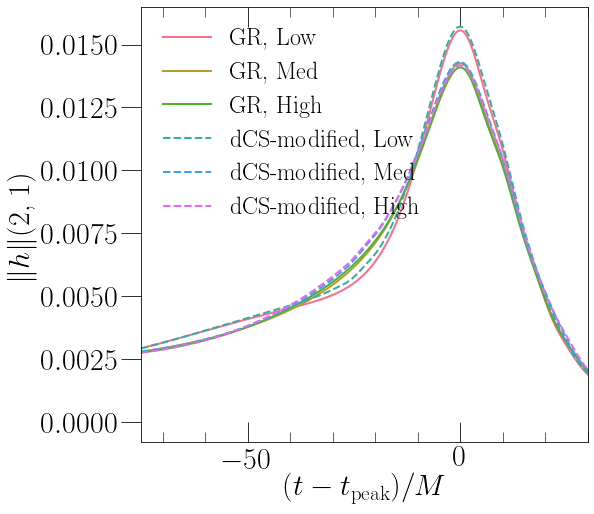

(2, 0)


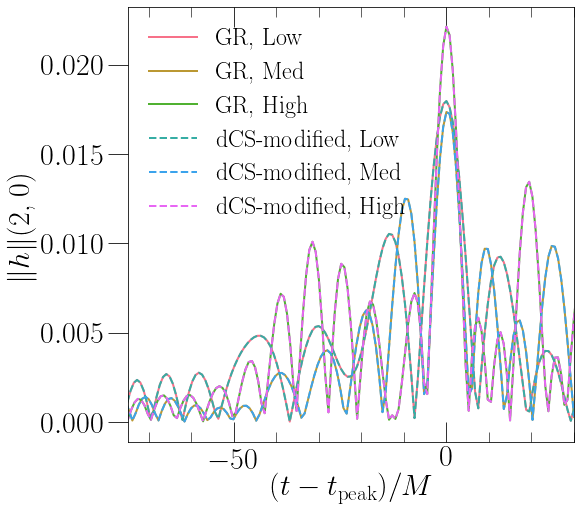

In [12]:


# Plot the SXS format strains from the simulations
def PlotSXSStrainResolutions(mode):
    
    f, ax = plt.subplots(1, figsize=(8,8))
    order = 2
    
    cs = sns.color_palette('husl', n_colors=6)
    
    i = 0
    for ell, label, ls in zip([0.0, 0.226], ['GR', 'dCS-modified'], ['-', '--']):
        
        for lev, res in zip([0,1,2], ['Low', 'Med', 'High']):
            p = "Waveforms"
            #p = "Waveforms/Lev" + str(lev)

            time, strain = ReadExtrapolatedMode(p, "dCSModified", mode, lev, order, ell=ell)
            #time, strain = ReadExtrapolatedMode(p, "DeltaStrain", mode, order, ell=ell, lev=lev)
            time = SubtractPeakTimeMode(time, strain)
            ax.plot(time, np.abs(strain), label=label+', ' + res, lw = 2.0, ls=ls, color=cs[i])
            i = i + 1
            
    legend = ax.legend(fontsize=24, loc='best', frameon=False, ncol=1)
    ax.set_ylabel(r'$\|h\|$' + str(mode), fontsize=30)
    ax.set_xlim(-75, 30)
    #ax.set_ylim(0.0, 0.45)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    #ax.set_yscale('log')
    #plt.tight_layout()
    #plt.savefig('SXSResolutions.pdf')
    plt.show()     

#modes = [(l,m) for l in range(2,9) for m in range(-l,l+1)]
modes = [(2,2), (4,4), (3,3), (3,2), (2,1), (2,0)]
for mode in modes:
    print(mode)
    PlotSXSStrainResolutions(mode)